In [103]:
import os
import csv
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

In [104]:
tf.get_logger().setLevel('ERROR')
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
print(f'Tensorflow: {tf.__version__}')
print('GPU is', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'not available')

Tensorflow: 2.4.0
GPU is available


In [96]:
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd.read_csv('nlp-getting-started/test.csv')
df_submission = pd.read_csv('nlp-getting-started/sample_submission.csv')

seed = 42

X_train, X_valid, y_train, y_valid = train_test_split(
    df_train['text'].tolist(), 
    df_train['target'].tolist(), 
    test_size=0.2, 
    stratify = df_train['target'].tolist(), 
    random_state=seed)


train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))

In [97]:
train_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [98]:
# num_threads = 4
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.shuffle(len(train_ds))
# train_ds = train_ds.map(parse_function, num_parallel_calls=num_threads)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

valid_ds = valid_ds.batch(batch_size)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [105]:
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd.read_csv('nlp-getting-started/test.csv')
df_submission = pd.read_csv('nlp-getting-started/sample_submission.csv')

X_train = df_train.text.values
y_train = df_train.target.values
X_test = df_test.text.values

In [6]:
# convert loaded data into numpy
train_X, train_y = tfds.as_numpy(train_ds)
valid_X, valid_y = tfds.as_numpy(valid_ds)
test_X, test_y = tfds.as_numpy(test_ds)

In [106]:
# embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
embedding = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1'
# embedding = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1'
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [107]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_11 (KerasLayer)  (None, 50)                48190600  
_________________________________________________________________
dense_24 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=[tf.keras.metrics.BinaryAccuracy()])

In [109]:
%%time

# history = model.fit(
#     train_ds,
#     epochs=10,
#     validation_data=valid_ds,
#     verbose=2)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_split=0.2,
    verbose=2)


Epoch 1/10
191/191 - 7s - loss: 0.5771 - binary_accuracy: 0.6864 - val_loss: 0.5014 - val_binary_accuracy: 0.7584
Epoch 2/10
191/191 - 6s - loss: 0.4006 - binary_accuracy: 0.8268 - val_loss: 0.4656 - val_binary_accuracy: 0.8083
Epoch 3/10
191/191 - 6s - loss: 0.2692 - binary_accuracy: 0.8961 - val_loss: 0.4999 - val_binary_accuracy: 0.7912
Epoch 4/10
191/191 - 6s - loss: 0.1718 - binary_accuracy: 0.9396 - val_loss: 0.5465 - val_binary_accuracy: 0.7827
Epoch 5/10
191/191 - 7s - loss: 0.1141 - binary_accuracy: 0.9621 - val_loss: 0.6250 - val_binary_accuracy: 0.7643
Epoch 6/10
191/191 - 6s - loss: 0.0752 - binary_accuracy: 0.9752 - val_loss: 0.7103 - val_binary_accuracy: 0.7564
Epoch 7/10
191/191 - 7s - loss: 0.0554 - binary_accuracy: 0.9823 - val_loss: 0.7705 - val_binary_accuracy: 0.7557
Epoch 8/10
191/191 - 7s - loss: 0.0400 - binary_accuracy: 0.9870 - val_loss: 0.8518 - val_binary_accuracy: 0.7538
Epoch 9/10
191/191 - 6s - loss: 0.0333 - binary_accuracy: 0.9882 - val_loss: 0.8804 - va

In [29]:
tfhub_results = {}
tfhub_results['base'] = model.evaluate(
    df_test.text.values,
    verbose=2)

102/102 - 0s - loss: 0.0000e+00 - binary_accuracy: 0.0000e+00


In [45]:
pickle_out = open('tfhub_results.pkl', 'wb')
pickle.dump(tfhub_results, pickle_out)
pickle_out.close()

In [47]:
tfhub_results

{'base': [0.0, 0.0]}

In [30]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))
    fig.subplots_adjust(hspace=0.5)
    
    ax1.plot(history['loss'], label='loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_ylim([0, 1])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['binary_accuracy'], label='Accuracy')
    ax2.plot(history['val_binary_accuracy'], label='Validation Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,binary_accuracy,val_loss,val_binary_accuracy,epoch
0,0.539539,0.736617,0.430675,0.820749,0
1,0.338788,0.862233,0.425596,0.829941,1
2,0.203276,0.927750,0.482826,0.812213,2


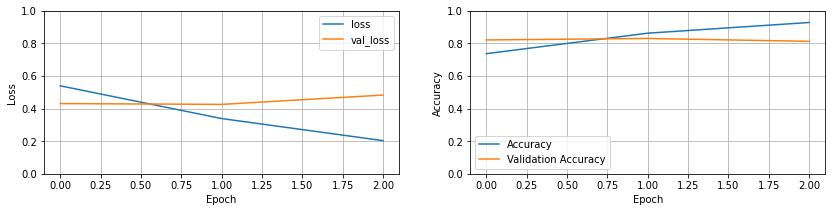

In [32]:
plot_history(hist)

In [50]:
pickle_in = open('tfhub_results.pkl', 'rb')
tfhub_results = pickle.load(pickle_in)

In [21]:
tfhub_results

array([[0.74293655],
       [0.46678466],
       [0.7377511 ],
       ...,
       [0.8744527 ],
       [0.81189823],
       [0.57296515]], dtype=float32)

In [33]:
test_pred = model.predict(
    df_test.text.values,
    verbose=2)

102/102 - 0s


In [37]:
df_submission['target'] = test_pred.round().astype(int)
df_submission.to_csv('submission.csv', index=False)
